In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.models as models
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm
from scipy.linalg import sqrtm
from torchsummary import summary
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from h5py import File as HDF5File
%matplotlib inline
import torch.nn as nn
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc

2025-06-30 14:50:20.817097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 14:50:20.857211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-30 14:50:20.857244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-30 14:50:20.858180: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-30 14:50:20.865459: I tensorflow/core/platform/cpu_feature_guar

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
# X_images = np.array(jet_mass_data['image'])
# X_eta = np.array(jet_mass_data['jet_eta'])
# X_dR = np.array(jet_mass_data['jet_delta_R'])
# X_mass = np.array(jet_mass_data['jet_mass'])
# X_phi = np.array(jet_mass_data['jet_phi'])
# X_pt = np.array(jet_mass_data['jet_pt'])
# X_signal = np.array(jet_mass_data['signal'])

# # Normalize the data
# X_images = (X_images - X_images.min()) / (X_images.max() - X_images.min())

# X_jet = [
#     X_images,
#     X_eta,
#     X_dR,
#     X_mass,
#     X_phi,
#     X_pt,
#     X_signal]

In [4]:
def plot_generated_samples(generator, kdes, batch_size=16, latent_dim=625):
    generator.eval()  # Set to eval mode to disable dropout/batchnorm updates

    # Latent vectors
    z_img = torch.randn(batch_size, latent_dim, 1, 1).cuda()
    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat = torch.cat([z_codings, z_noise], dim=1)
    z_feat = z_codings

    with torch.no_grad():
        gen_samples = generator(z_feat)

    gen_samples = gen_samples.unsqueeze(1).cpu()

    # Optional: normalize only if your generator outputs in [-1, 1]
    gen_samples = torch.clamp(gen_samples, 0, 1)
    
    print("Sample feature coding:", z_codings[1].cpu().numpy())

    fig, axes = plt.subplots(1, min(batch_size, 16), figsize=(min(batch_size, 16), 1))
    for i in range(min(batch_size, 16)):
        axes[i].imshow(gen_samples[i, 0].numpy(), cmap= 'viridis')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    generator.train()  # Restore training mode

def plot_metrics(g_losses, d_losses):
    epochs = range(1, len(g_losses) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, g_losses, label='Generator Loss', color='blue')
    plt.plot(epochs, d_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(dataset):
    # Stack all features
    all_features = torch.stack([dataset[i][1] for i in range(len(dataset))])
    
    feature_labels = [
        r"$\eta$", r"Mass", r"$p_T$", r"$\Delta R$",
        r"$\langle \Delta R \rangle$", r"$\sigma_{\Delta R}$",
        r"$\langle Pixel \rangle$", r"$\sigma_{Pixel}$"
    ]
    
    num_features = all_features.shape[1]
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    axs = axs.flatten()
    
    for i in range(num_features):
        axs[i].hist(all_features[:, i+1].cpu().numpy(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axs[i].set_title(f"Feature {i}: {feature_labels[i]}")
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.suptitle("Distributions of Input Features", fontsize=16, y=1.03)
    plt.show()

from scipy.stats import norm
from scipy.stats import gaussian_kde

def feature_distributions(dataset):
    all_features = torch.stack([dataset[i][1] for i in range(len(dataset))])
    
    feature_labels = [
        r"$\eta$", r"Mass", r"$p_T$", r"$\Delta R$",
        r"$\langle \Delta R \rangle$", r"$\sigma_{\Delta R}$",
        r"$\langle \mathrm{Pixel} \rangle$", r"$\sigma_{\mathrm{Pixel}}$"
    ]
    
    num_features = all_features.shape[1]
    fig, axs = plt.subplots(3, 3, figsize=(16, 10))
    axs = axs.flatten()

    kde_fits = {}
    
    for i in range(num_features-1):
        data = all_features[:, i+1].cpu().numpy()
        mean_val = data.mean()
        std_val = data.std()

        # Histogram
        counts, bins, _ = axs[i].hist(data, bins=50, alpha=0.4, color='skyblue', edgecolor='black', density=True)

        # KDE fit
        kde = gaussian_kde(data)
        kde_fits[feature_labels[i]] = kde
        x_vals = np.linspace(bins[0], bins[-1], 500)
        axs[i].plot(x_vals, kde(x_vals), label='KDE', color='green')

        # Gaussian fit
        gaussian = norm.pdf(x_vals, loc=mean_val, scale=std_val)
        axs[i].plot(x_vals, gaussian, 'r--', label=f'Gaussian\nμ={mean_val:.3f}, σ={std_val:.3f}')

        axs[i].set_title(feature_labels[i], fontsize=12)
        axs[i].set_xlabel(feature_labels[i])
        axs[i].set_ylabel("Density")
        axs[i].grid(True)
        axs[i].legend()

    plt.tight_layout()
    plt.suptitle("Feature Distributions with Gaussian and KDE Fits", fontsize=16, y=1.03)
    plt.show()
    return kde_fits

def sample_fit_noise(kde_fits, num_samples=1):
    
    feature_labels = [
        r"$\eta$", r"Mass", r"$p_T$", r"$\Delta R$",
        r"$\langle \Delta R \rangle$", r"$\sigma_{\Delta R}$",
        r"$\langle \mathrm{Pixel} \rangle$", r"$\sigma_{\mathrm{Pixel}}$"
    ]

    samples = []
    for label in feature_labels:
        kde = kde_fits[label]
        sampled = kde.resample(num_samples).T.squeeze()
        samples.append(sampled)

    stacked = np.stack(samples, axis=1)  # shape (num_samples, 9)
    return torch.tensor(stacked, dtype=torch.float32)

class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach

    def forward(self, x):
        if self.training and self.sigma > 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = torch.randn_like(x) * scale
            return x + sampled_noise
        return x

In [5]:
class JetDataset(Dataset):
    def __init__(self, data, n_events):
        self.images = torch.tensor(data['image'][:n_events], dtype=torch.float32)
        self.flipped_images = torch.flip(self.images,[1])
        # Normalize
        self.images = (self.images - self.images.min()) / (self.images.max() - self.images.min())
        self.flipped_images = (self.flipped_images - self.flipped_images.min()) / (self.flipped_images.max() - self.flipped_images.min())

        # ----- ΔR Calculation -----
        # Image shape: (25, 25)
        H, W = self.images[0].shape
        center_x, center_y = (W - 1) / 2, (H - 1) / 2  # center = (12, 12)

        # Coordinate grid
        x_coords, y_coords = torch.meshgrid(
            torch.arange(W, dtype=torch.float32),
            torch.arange(H, dtype=torch.float32),
            indexing='ij'
        )

        # Distance from center
        dists = torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)

        # Weighted: sum(pixel * distance) / sum(pixel)
        weights = self.images
        weight_norm = self.images.max()

        dR = (weights * dists) / weight_norm

        # dim = (1,2,3)
        dR_mean = dR.mean(dim = (1,2))
        dR_std = dR.std(dim = (1,2))
        print(f"dR Mean: {dR_mean.shape}")
        print(f"dR STD: {dR_std.shape}")
        
        # Pixel stats
        pixel_mean = weights.mean(dim = (1,2))
        pixel_std = weights.std(dim = (1,2))
        print(f"Pixel Mean: {pixel_mean.shape}")
        print(f"Pixel STD: {pixel_std.shape}")

        self.features = torch.tensor(np.stack([
            data['signal'][:n_events],
            data['jet_eta'][:n_events],
            data['jet_pt'][:n_events],
            data['jet_mass'][:n_events],
            data['jet_delta_R'][:n_events],
            dR_mean, 
            dR_std, 
            pixel_mean, 
            pixel_std
        ], axis=1), dtype=torch.float32)
        
        self.flipped_features = torch.tensor(np.stack([
            data['signal'][:n_events],
            -data['jet_eta'][:n_events],
            data['jet_pt'][:n_events],
            data['jet_mass'][:n_events],
            data['jet_delta_R'][:n_events],
            dR_mean, 
            dR_std, 
            pixel_mean, 
            pixel_std,
        ], axis=1), dtype=torch.float32)

        # Normalize just pt and mass features here also
        # Normalize jet_mass (index 2)
        self.features[:, 2] = (self.features[:, 2]-self.features[:, 2].min()) / (self.features[:, 2].abs().max()-self.features[:, 2].min())
        
        # Normalize jet_pt (index 3)
        self.features[:, 3] = (self.features[:, 3]-self.features[:, 3].min()) / (self.features[:, 3].abs().max()-self.features[:, 3].min())
        
        # Same for flipped features
        self.flipped_features[:, 2] = (self.flipped_features[:, 2]-self.flipped_features[:, 2].min()) / (self.flipped_features[:, 2].max()-self.flipped_features[:, 2].min())
        self.flipped_features[:, 3] = (self.flipped_features[:, 3]-self.flipped_features[:, 3].min()) / (self.flipped_features[:, 3].max()-self.flipped_features[:, 3].min())

        print("ΔR min:", dR.min().item())
        print("ΔR max:", dR.max().item())
        
        print("ΔR mean min:", dR_mean.min().item())
        print("ΔR mean max:", dR_mean.max().item())
        
        print("ΔR std min:", dR_std.min().item())
        print("ΔR std max:", dR_std.max().item())
        
        print("Weights (pixel intensity) min:", weights.min().item())
        print("Weights (pixel intensity) max:", weights.max().item())
        
        print("Pixel mean min:", pixel_mean.min().item())
        print("Pixel mean max:", pixel_mean.max().item())
        
        print("Pixel std min:", pixel_std.min().item())
        print("Pixel std max:", pixel_std.max().item())


    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        image = self.images[idx]
        flipped_image = self.flipped_images[idx]
        features = self.features[idx]
        flipped_features = self.flipped_features[idx]
        weight_norm = self.images.max()

        return image, features, flipped_image, flipped_features, weight_norm
        
class Generator(nn.Module):
    def __init__(self, latent_dim=25*25):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.1)

        self.feature_gen = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(256, 25*25),
            nn.LayerNorm(25*25),
            self.noise
        )
        
        self.image_gen = nn.Sequential(
            
            
            # 1x1 → 4x4
            nn.ConvTranspose2d(25*25, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),

            # 4x4 → 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),

            # 8x8 → 16x16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),

            # 16x16 → 25x25
            nn.ConvTranspose2d(64, 1, kernel_size=10, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        img = img.view(-1, 625, 1, 1)
        img = self.image_gen(img)
        img = img.squeeze(1)
        
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.noise = GaussianNoise(sigma=.1)
        
        # Flattened image: 25*25 = 625
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten(),
            self.noise
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(4672, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.6),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.6),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

dR Mean: torch.Size([8726])
dR STD: torch.Size([8726])
Pixel Mean: torch.Size([8726])
Pixel STD: torch.Size([8726])
ΔR min: 0.0
ΔR max: 2.699702024459839
ΔR mean min: 0.0010631715413182974
ΔR mean max: 0.007017849944531918
ΔR std min: 0.007734084036201239
ΔR std max: 0.10973722487688065
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0014575079549103975
Pixel mean max: 0.001826878753490746
Pixel std min: 0.007443747017532587
Pixel std max: 0.04001035913825035


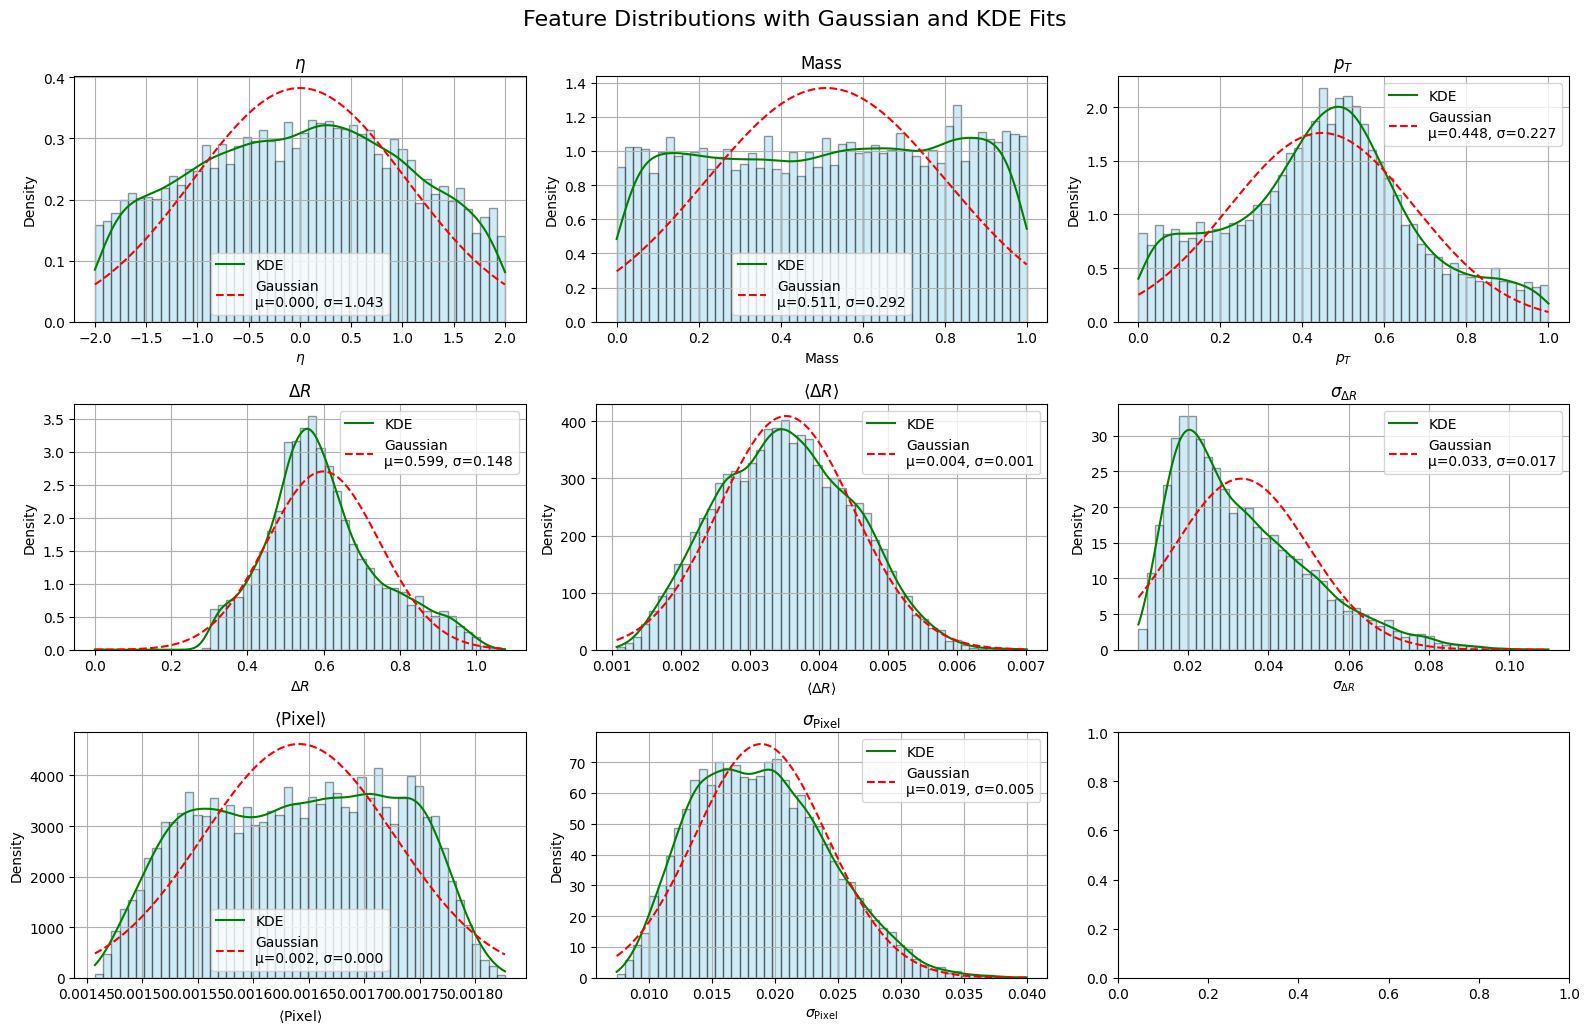

Number of samples: 8726
Image shape: torch.Size([8726, 25, 25])
Feature shape: torch.Size([8726, 9])


In [6]:
batch_size = 128
n_events = int(0.01 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

[Epoch 1/30] [D loss: 0.6407] [G loss: 1.7896] Validity_loss: 1.2153; Symmetry_loss: 0.0000; Stat_loss: 0.5743
Sample feature coding: [ 1.         -0.8886692   0.38617954  0.48090136  0.60326105  0.00290124
  0.04563266  0.0017217   0.02234528]


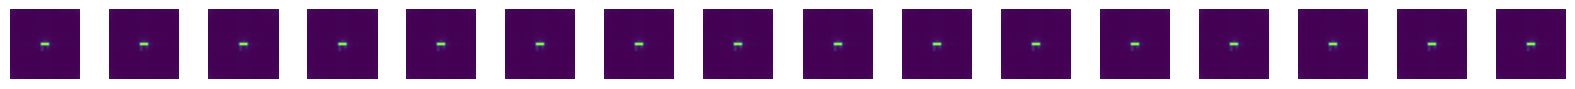

[Epoch 2/30] [D loss: 0.3929] [G loss: 0.6147] Validity_loss: 0.2846; Symmetry_loss: 0.0000; Stat_loss: 0.3302
Sample feature coding: [0.         0.03987807 0.5792703  0.44163206 0.59401375 0.00389004
 0.02381393 0.00166204 0.01810427]


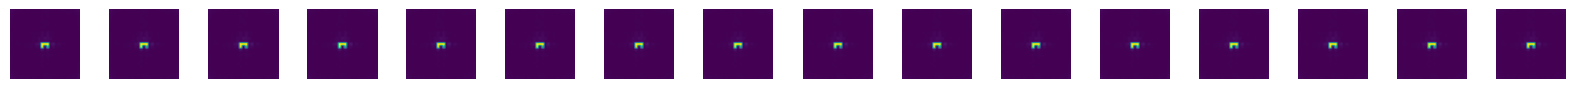

[Epoch 3/30] [D loss: 0.2053] [G loss: 0.3114] Validity_loss: 0.1094; Symmetry_loss: 0.0000; Stat_loss: 0.2020
Sample feature coding: [ 0.         -0.88988644  0.59630567  0.40111592  0.46099013  0.00441468
  0.06078975  0.00154492  0.01828289]


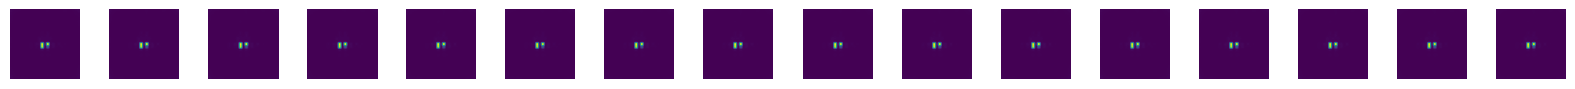

[Epoch 4/30] [D loss: 0.0863] [G loss: 0.2034] Validity_loss: 0.0663; Symmetry_loss: 0.0000; Stat_loss: 0.1371
Sample feature coding: [ 0.         -0.25339282  0.23191424  0.5077796   0.7243139   0.00351478
  0.01429948  0.00171799  0.01791495]


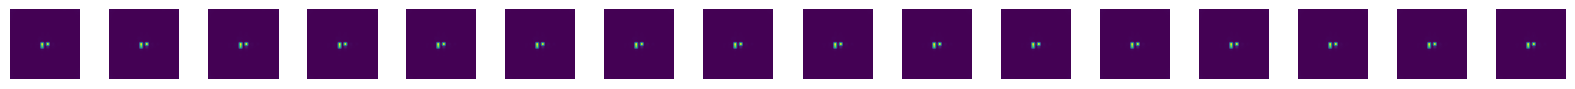

[Epoch 5/30] [D loss: 0.0389] [G loss: 0.1158] Validity_loss: 0.0176; Symmetry_loss: 0.0000; Stat_loss: 0.0982
Sample feature coding: [1.         0.15945302 0.4445344  0.6636351  0.60616904 0.00258747
 0.04558518 0.00162127 0.02319532]


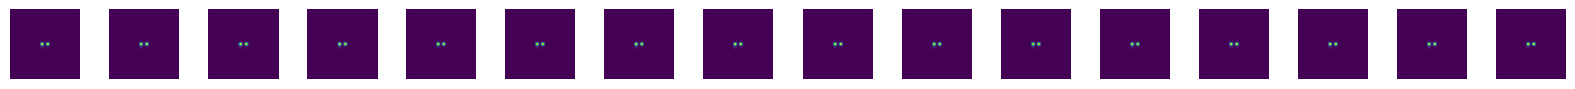

[Epoch 6/30] [D loss: 0.0216] [G loss: 0.0995] Validity_loss: 0.0197; Symmetry_loss: 0.0000; Stat_loss: 0.0798
Sample feature coding: [0.         1.1650581  0.23338613 0.41691062 0.58260757 0.00342678
 0.02511902 0.00156539 0.02161423]


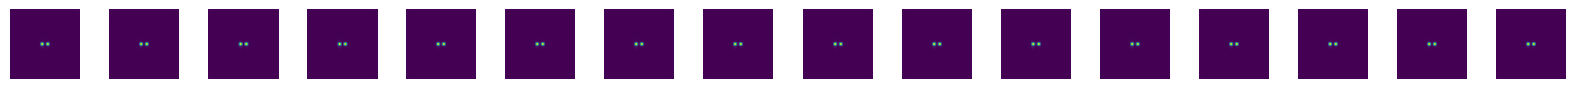

[Epoch 7/30] [D loss: 0.0141] [G loss: 0.0869] Validity_loss: 0.0118; Symmetry_loss: 0.0000; Stat_loss: 0.0751
Sample feature coding: [ 1.         -0.6581672   0.52645177  0.58510953  0.93805176  0.00267766
  0.0219133   0.00157668  0.0189663 ]


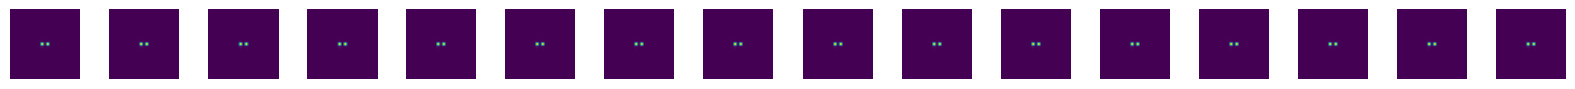

[Epoch 8/30] [D loss: 0.0097] [G loss: 0.0800] Validity_loss: 0.0046; Symmetry_loss: 0.0000; Stat_loss: 0.0753
Sample feature coding: [1.         0.13355231 0.6840403  0.6748342  0.834805   0.00237972
 0.06050197 0.0016497  0.02648173]


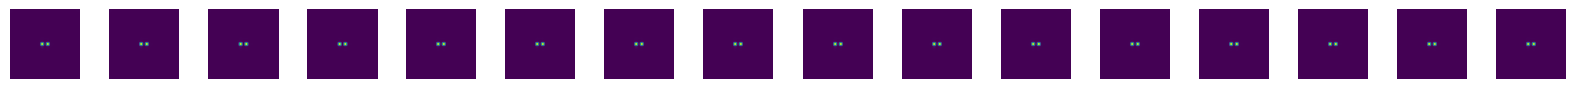

[Epoch 9/30] [D loss: 0.0079] [G loss: 0.0699] Validity_loss: 0.0144; Symmetry_loss: 0.0000; Stat_loss: 0.0555
Sample feature coding: [ 0.         -0.18799633  0.15923412  0.26373932  0.72937644  0.00349357
  0.02807386  0.00170536  0.01752858]


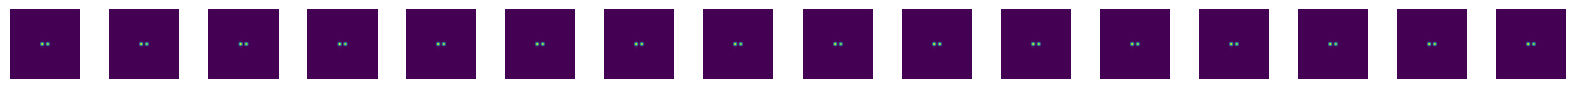

[Epoch 10/30] [D loss: 0.0070] [G loss: 0.0513] Validity_loss: 0.0112; Symmetry_loss: 0.0000; Stat_loss: 0.0402
Sample feature coding: [1.         1.0219299  0.59313375 0.29109263 0.44895372 0.00414587
 0.01411912 0.00176329 0.02317926]


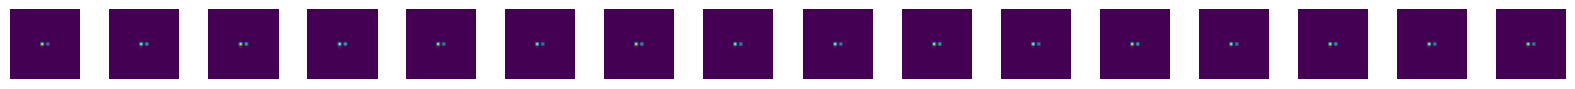

[Epoch 11/30] [D loss: 0.0067] [G loss: 0.0462] Validity_loss: 0.0126; Symmetry_loss: 0.0000; Stat_loss: 0.0336
Sample feature coding: [ 0.0000000e+00 -1.9415016e+00  4.6582201e-01  4.7191191e-01
  5.4667115e-01  4.2518522e-03  7.5574364e-03  1.6686658e-03
  2.2015939e-02]


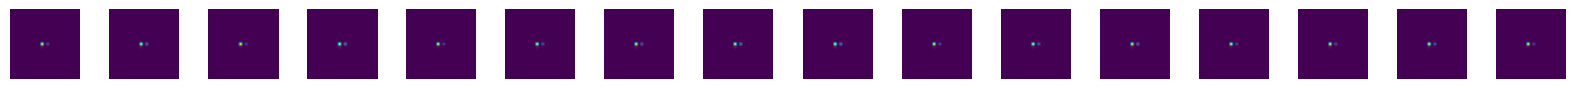

[Epoch 12/30] [D loss: 0.0061] [G loss: 0.0396] Validity_loss: 0.0110; Symmetry_loss: 0.0000; Stat_loss: 0.0286
Sample feature coding: [ 1.0000000e+00 -1.8645638e+00  2.6583862e-01  4.6030807e-01
  8.3561009e-01  4.6099005e-03  4.0618390e-02  1.5455027e-03
  1.2927424e-02]


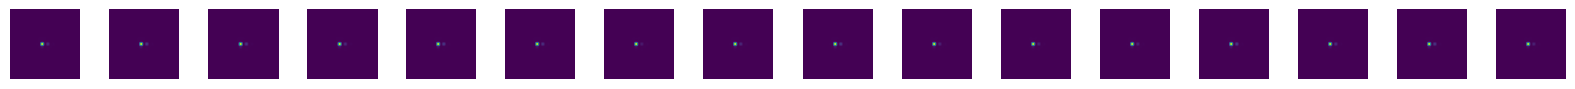

[Epoch 13/30] [D loss: 0.0034] [G loss: 0.0311] Validity_loss: 0.0056; Symmetry_loss: 0.0000; Stat_loss: 0.0256
Sample feature coding: [ 1.         -0.72278994  0.07767551  0.46373835  0.6867173   0.00329622
  0.02973517  0.00172922  0.01737683]


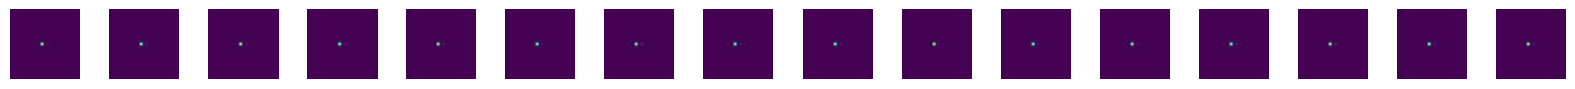

[Epoch 14/30] [D loss: 0.0029] [G loss: 0.0316] Validity_loss: 0.0049; Symmetry_loss: 0.0000; Stat_loss: 0.0266
Sample feature coding: [ 1.         -0.66381854  0.8841926   0.6299178   0.4617282   0.00253434
  0.01312657  0.00176085  0.02995545]


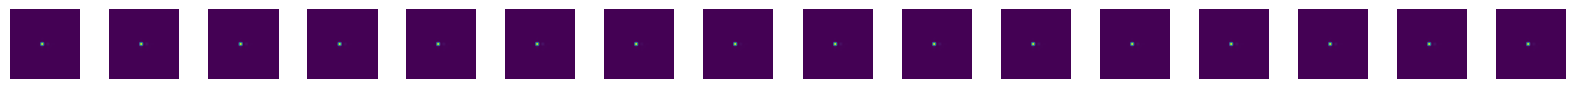

[Epoch 15/30] [D loss: 0.0025] [G loss: 0.0280] Validity_loss: 0.0046; Symmetry_loss: 0.0000; Stat_loss: 0.0234
Sample feature coding: [1.         0.14323407 0.10161848 0.60323334 0.87325394 0.00245609
 0.01453998 0.00172452 0.01874281]


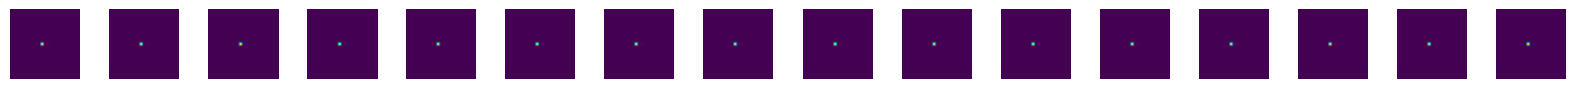

[Epoch 16/30] [D loss: 0.0017] [G loss: 0.0295] Validity_loss: 0.0031; Symmetry_loss: 0.0000; Stat_loss: 0.0265
Sample feature coding: [ 0.         -0.02744374  0.22695638  0.07934836  0.9889059   0.00562556
  0.03713261  0.00157758  0.01922869]


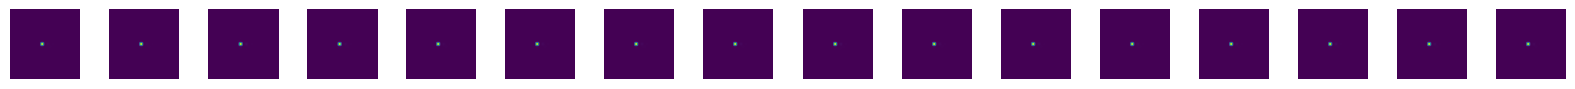

[Epoch 17/30] [D loss: 0.0018] [G loss: 0.0265] Validity_loss: 0.0021; Symmetry_loss: 0.0000; Stat_loss: 0.0244
Sample feature coding: [1.         0.06111818 0.59472597 0.3814502  0.32607993 0.00474734
 0.07427226 0.00179701 0.01266842]


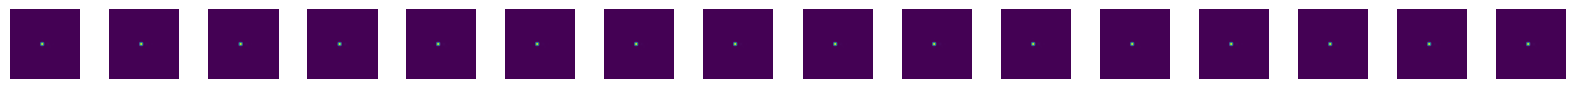

[Epoch 18/30] [D loss: 0.0017] [G loss: 0.0270] Validity_loss: 0.0037; Symmetry_loss: 0.0000; Stat_loss: 0.0233
Sample feature coding: [1.         0.7302049  0.30100572 0.35980827 0.4706038  0.00584106
 0.06797223 0.00176035 0.01136645]


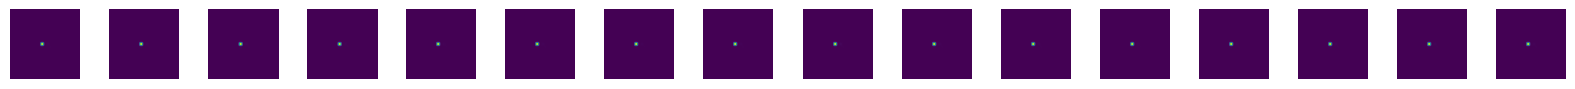

[Epoch 19/30] [D loss: 0.0012] [G loss: 0.0285] Validity_loss: 0.0036; Symmetry_loss: 0.0000; Stat_loss: 0.0248
Sample feature coding: [0.         0.46233132 0.27410838 0.07796527 0.44019982 0.0028283
 0.04440095 0.00152642 0.01116646]


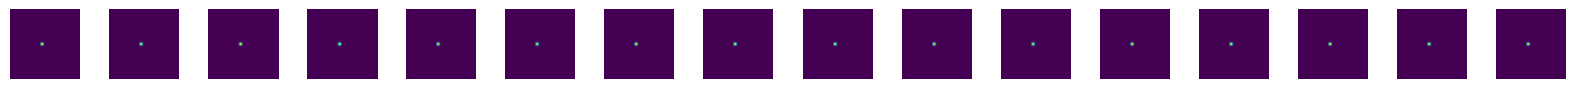

[Epoch 20/30] [D loss: 0.0010] [G loss: 0.0263] Validity_loss: 0.0030; Symmetry_loss: 0.0000; Stat_loss: 0.0233
Sample feature coding: [ 0.         -1.657363    0.03204275  0.6120754   0.7128271   0.00347573
  0.01818134  0.0017365   0.02367248]


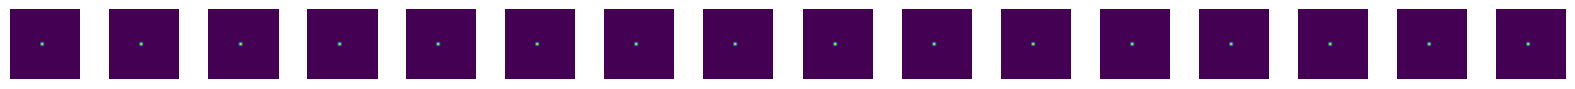

[Epoch 21/30] [D loss: 0.0012] [G loss: 0.0257] Validity_loss: 0.0026; Symmetry_loss: 0.0000; Stat_loss: 0.0230
Sample feature coding: [1.         0.3950721  0.8868016  0.24173252 0.8248705  0.00388922
 0.00872278 0.0016047  0.0148312 ]


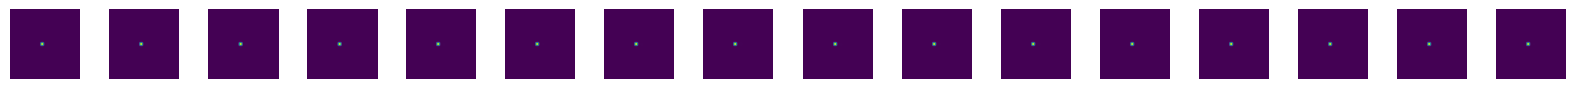

[Epoch 22/30] [D loss: 0.0011] [G loss: 0.0225] Validity_loss: 0.0005; Symmetry_loss: 0.0000; Stat_loss: 0.0220
Sample feature coding: [ 1.         -0.55273104  0.16682783  0.38718477  0.6348877   0.00410326
  0.01473038  0.00152816  0.01515868]


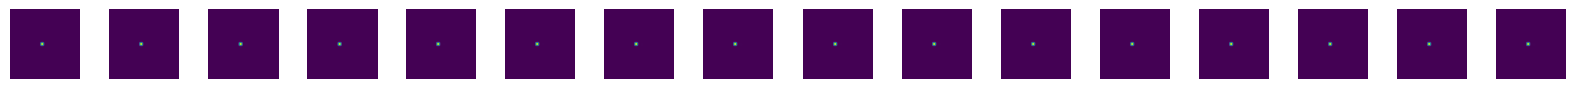

[Epoch 23/30] [D loss: 0.0006] [G loss: 0.0240] Validity_loss: 0.0012; Symmetry_loss: 0.0000; Stat_loss: 0.0228
Sample feature coding: [ 0.         -0.07202326  0.71855646  0.60150415  0.65034187  0.0052225
  0.01598866  0.00147946  0.01486989]


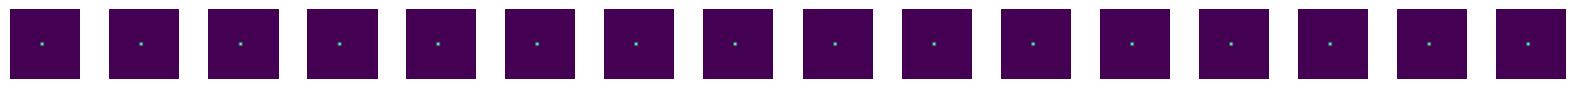

[Epoch 24/30] [D loss: 0.0006] [G loss: 0.0228] Validity_loss: 0.0007; Symmetry_loss: 0.0000; Stat_loss: 0.0221
Sample feature coding: [0.         1.516753   0.9245944  0.60677326 0.4534668  0.00254502
 0.01805601 0.0016539  0.01513753]


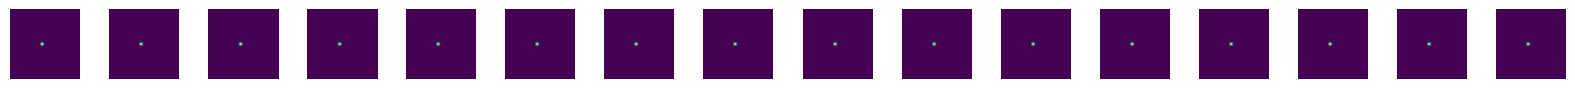

[Epoch 25/30] [D loss: 0.0006] [G loss: 0.0245] Validity_loss: 0.0013; Symmetry_loss: 0.0000; Stat_loss: 0.0232
Sample feature coding: [ 0.0000000e+00 -1.1494765e+00 -8.3387457e-04  1.6829142e-01
  5.8573520e-01  1.9094903e-03  2.6108108e-02  1.7336668e-03
  2.6530135e-02]


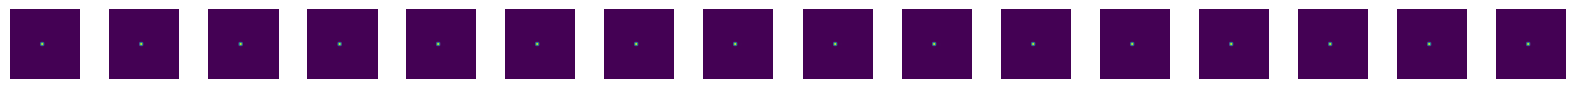

[Epoch 26/30] [D loss: 0.0007] [G loss: 0.0222] Validity_loss: 0.0007; Symmetry_loss: 0.0000; Stat_loss: 0.0214
Sample feature coding: [ 0.0000000e+00 -1.6430358e+00  2.1613970e-01  3.4373823e-01
  6.8248421e-01  1.7150927e-03  4.8314799e-02  1.6223763e-03
  2.7421547e-02]


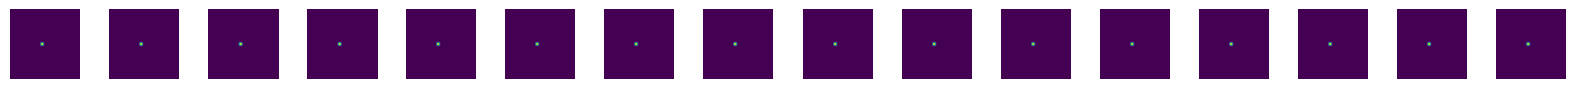

[Epoch 27/30] [D loss: 0.0006] [G loss: 0.0230] Validity_loss: 0.0017; Symmetry_loss: 0.0000; Stat_loss: 0.0213
Sample feature coding: [0.         0.6515792  0.65043306 0.7412757  0.55479777 0.00429808
 0.02319988 0.00164106 0.02167348]


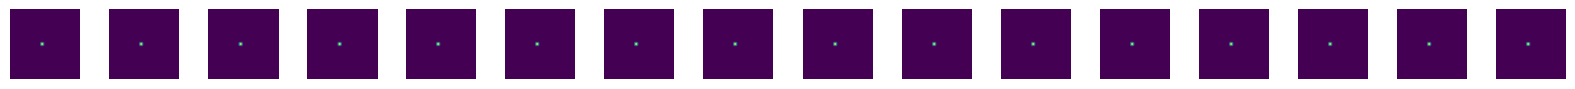

[Epoch 28/30] [D loss: 0.0008] [G loss: 0.0235] Validity_loss: 0.0013; Symmetry_loss: 0.0000; Stat_loss: 0.0222
Sample feature coding: [1.         1.0857651  0.5873639  0.50667673 0.41098416 0.00443351
 0.0211715  0.00156822 0.01643477]


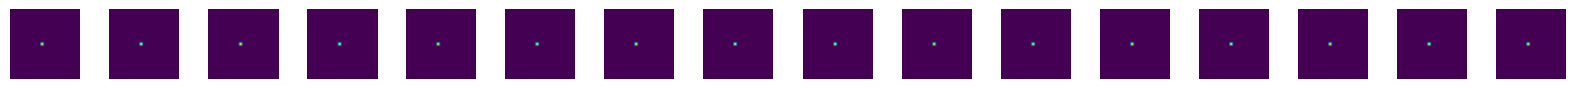

[Epoch 29/30] [D loss: 0.0010] [G loss: 0.0210] Validity_loss: 0.0005; Symmetry_loss: 0.0000; Stat_loss: 0.0205
Sample feature coding: [0.         0.49963942 0.42743552 0.19956537 0.4929877  0.00306261
 0.02933896 0.00162631 0.01784034]


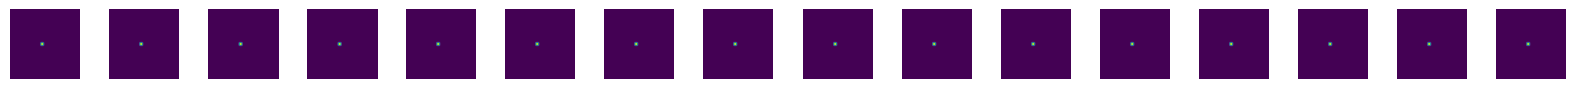

[Epoch 30/30] [D loss: 0.0006] [G loss: 0.0212] Validity_loss: 0.0003; Symmetry_loss: 0.0000; Stat_loss: 0.0209
Sample feature coding: [ 0.         -0.08278114  0.05845202  0.6862987   0.4748822   0.0050841
  0.02482785  0.00152558  0.02060527]


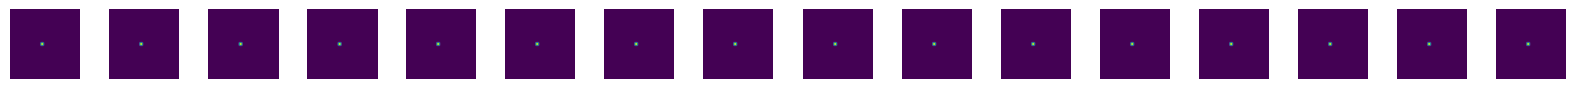

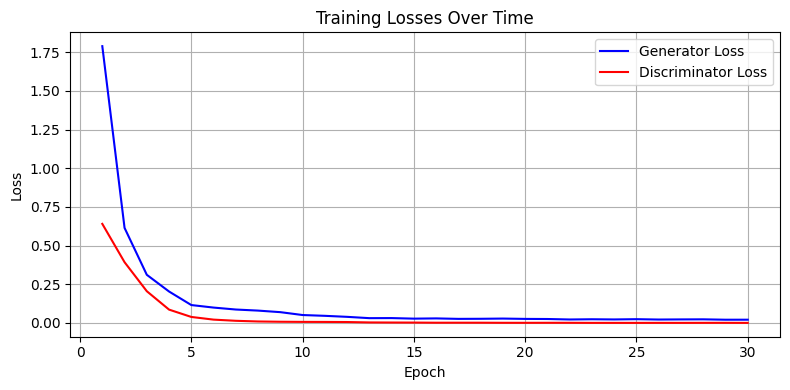

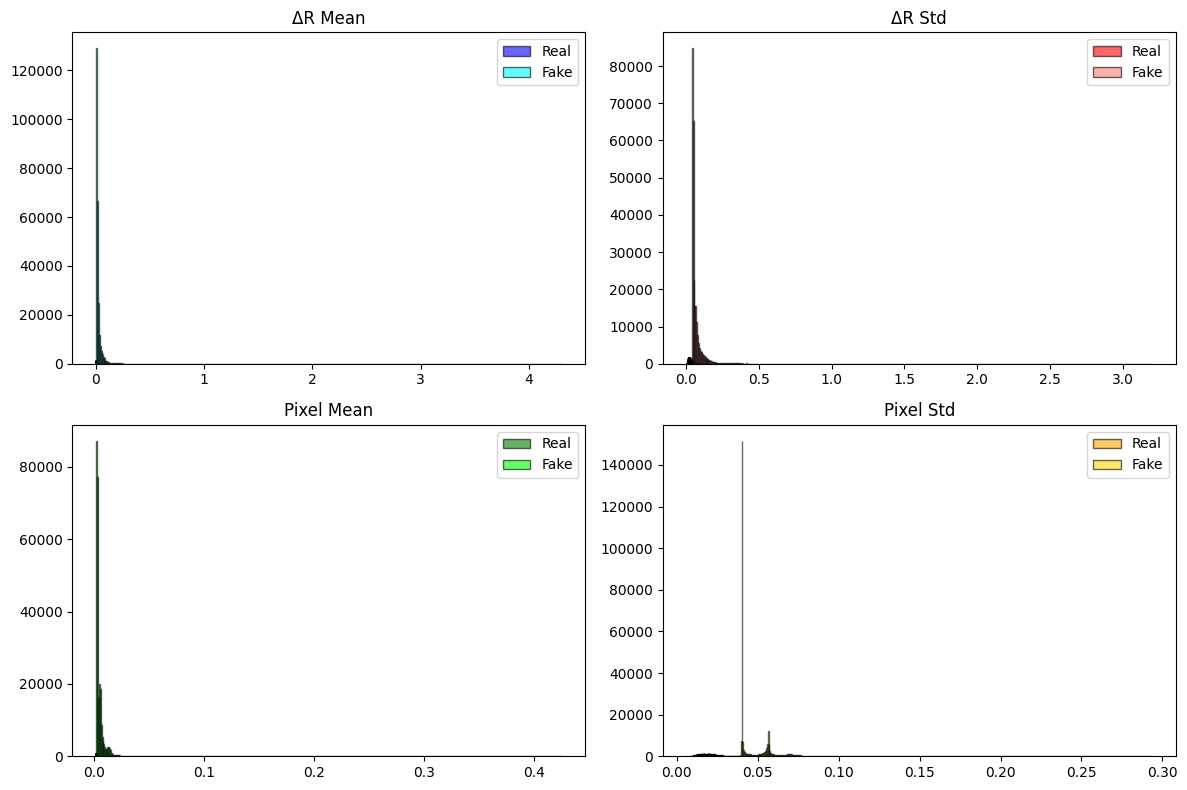

In [7]:
tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []



latent_dim = 25*25
lr = 0.0005
n_epochs = 30

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

g_losses = []
d_losses = []

# Image shape: (25, 25)
H, W = (25,25)
center_x, center_y = (W - 1) / 2, (H - 1) / 2  # center = (12, 12)

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()

for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features, weight_norm) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()
        weight_norm = weight_norm.cuda()
        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 10 == 0:
            optimizer_D.zero_grad()
    
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
            z_feat1 = z_codings

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_feat1)
            fake_img = fake_img.unsqueeze(1)
            fake_feat = z_codings[:,:4]
            # print(fake_feat.shape)
            
            # Generate eta-flipped data
            z_feat2 = z_feat1.clone()
            z_feat2[:, 1] *= -1
            
            fake_flipped_img = generator(z_feat2)
            fake_flipped_img = fake_flipped_img.unsqueeze(1)
            fake_flipped_feat = z_feat2[:,:4]
            # print(fake_flipped_feat.shape)
            
            # Get predictions and labels

            real_pred = discriminator(real_img, real_feat[:,:4])
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_feat[:,:4])
            fake_pred = discriminator(fake_img.detach(), fake_feat.detach())
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_feat)
            
            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)
 
            zeros = torch.zeros(2*len(real_pred))
            ones = torch.ones(2*len(fake_pred))
            labels = (torch.cat([zeros, ones], dim=0)).cuda()
    
            # # Testing predictions and labels
            # print(f"Predictions: {preds.shape}")
            # print(preds[0])
            # print(f"Labels: {labels.shape}")
            # print(labels[0])
    
            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)
            
            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()

            # Generate fake data
            z_img1 = torch.randn(batch_size, 25*25, 1, 1).cuda()

            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
            z_feat1 = z_codings

            fake_img = generator(z_feat1)
            fake_img = fake_img.unsqueeze(1)
            fake_feat = z_codings[:,:4]
            # print(fake_feat.shape)

            # Generate eta-flipped data
            z_feat2 = z_feat1.clone()
            z_feat2[:, 1] *= -1

            fake_flipped_img = generator(z_feat2)
            fake_flipped_img = fake_flipped_img.unsqueeze(1)
            #fake_flipped_feat = torch.cat([z_codings, fake_flipped_feat], dim = 1)
            fake_flipped_feat = z_feat2[:,:4]
            # print(fake_flipped_feat.shape)
            
            # # Feature symmetry loss: all except η (index 0) should match
            # feat_sym_loss = torch.nn.MSELoss()(fake_feat[:, 1:], fake_flipped_feat[:, 1:]) / batch_size
            # eta_flip_loss = torch.nn.MSELoss()(fake_feat[:, 0], -fake_flipped_feat[:, 0]) / batch_size  # η → -η

            # symmetry_loss = feat_sym_loss + eta_flip_loss

            symmetry_loss = 0
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_feat)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_feat)
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = 0.5 * bce(d_out, target) #+ .5 * bce(d_out_flip, target)


            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists) / weight_norm[0]

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = fake_img.squeeze(1).mean(dim = (1,2))
            fake_pixel_std = fake_img.squeeze(1).std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists) / weight_norm[0]

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = fake_flipped_img.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = fake_flipped_img.squeeze(1).std(dim = (1,2))


            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]

            # Statistical loss
            dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean)) / batch_size
            dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std)) / batch_size
            pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean)) / batch_size
            pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std)) / batch_size
            
            stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between original and flipped non-eta features      (discriminator should handle this implicitly, hence the 0)
            # + the difference between input and output dR and pixel statistics
            
            alpha = 5
            beta = 0
            chi = 1000
            
            g_loss = (alpha*validity_loss + beta*symmetry_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()


            # Track fake stats
            tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
            tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
            tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
            tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
            
            # Track real stats from z_codings
            tracked_real_dR_mean.append(z_codings[:, 5].detach().cpu())
            tracked_real_dR_std.append(z_codings[:, 6].detach().cpu())
            tracked_real_pixel_mean.append(z_codings[:, 7].detach().cpu())
            tracked_real_pixel_std.append(z_codings[:, 8].detach().cpu())


    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] Validity_loss: {alpha*validity_loss:.4f}; Symmetry_loss: {beta*symmetry_loss:.4f}; Stat_loss: {chi*stat_loss:.4f}")
    
    z_img = torch.randn(batch_size, 25*25, 1, 1).cuda() 
            
    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, kdes, latent_dim)


plot_metrics(g_losses, d_losses)

# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy()
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy()
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy()
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy()

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy()
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy()
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy()
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy()

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(real_dR_mean_vals, bins=500, alpha=0.6, label='Real', color='blue', edgecolor='black')
axs[0, 0].hist(fake_dR_mean_vals, bins=500, alpha=0.6, label='Fake', color='cyan', edgecolor='black')
axs[0, 0].set_title('ΔR Mean')
axs[0, 0].legend()

axs[0, 1].hist(real_dR_std_vals, bins=500, alpha=0.6, label='Real', color='red', edgecolor='black')
axs[0, 1].hist(fake_dR_std_vals, bins=500, alpha=0.6, label='Fake', color='salmon', edgecolor='black')
axs[0, 1].set_title('ΔR Std')
axs[0, 1].legend()

axs[1, 0].hist(real_pixel_mean_vals, bins=500, alpha=0.6, label='Real', color='green', edgecolor='black')
axs[1, 0].hist(fake_pixel_mean_vals, bins=500, alpha=0.6, label='Fake', color='lime', edgecolor='black')
axs[1, 0].set_title('Pixel Mean')
axs[1, 0].legend()

axs[1, 1].hist(real_pixel_std_vals, bins=500, alpha=0.6, label='Real', color='orange', edgecolor='black')
axs[1, 1].hist(fake_pixel_std_vals, bins=500, alpha=0.6, label='Fake', color='gold', edgecolor='black')
axs[1, 1].set_title('Pixel Std')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

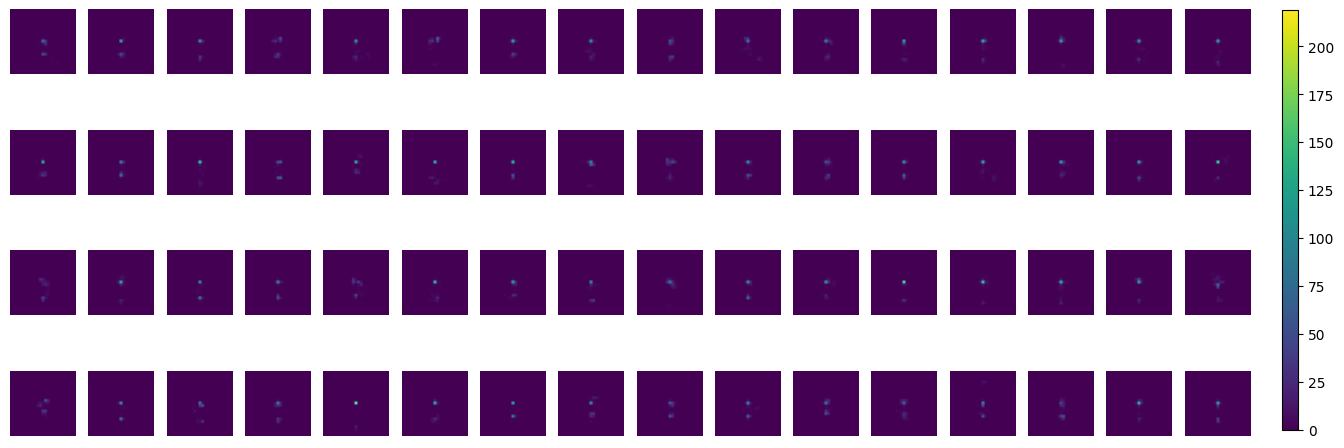

In [8]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = jet_mass_data['image'][:n_images].min()
vmax = jet_mass_data['image'][:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(jet_mass_data['image'][i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [9]:
for i in range(0, 5):
    pic = torch.from_numpy(X_images[10*i])
    grid = torchvision.utils.make_grid(pic, nrow=4, normalize=True)
    np_img = np.clip(grid.permute(1, 2, 0).numpy(), 0, 1)
    # Display as a grayscale image
    plt.imshow(1-np_img, cmap='gray')  # you can also try 'viridis', 'plasma', etc.
    plt.show()

NameError: name 'X_images' is not defined

In [ ]:
for i in range(0, 5):
    pic = torch.from_numpy(X_images[10*i])
    pic = torch.flip(pic,[1])
    grid = torchvision.utils.make_grid(pic, nrow=4, normalize=True)
    np_img = np.clip(grid.permute(1, 2, 0).numpy(), 0, 1)
    # Display as a grayscale image
    plt.imshow(1-np_img, cmap='gray')  # you can also try 'viridis', 'plasma', etc.
    plt.show()